<h1 Projet de reconnaissance vocale </h1>

# Les données:
Le dossier "data/raw" contient des milliers d'enregistrements audio de 10 personnes (5 hommes et 5 femmes) américaines. Le but de ce projet et d'analyser ces données et de construire un modèle simple de reconnaissance vocale. C'est à dire, reconnaitre la personne qui parle parmi les 10. Voici à quoi ressemble un enregistrement:

In [1]:
from IPython.display import Audio
import librosa

y1, sr1 = librosa.load("data/raw/f0001_us_f0001_00001.wav", sr=None)
Audio(data=y1, rate=sr1)



In [2]:
print(y1)
print(f"La taille du fichier audio est {y1.shape}")

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.4414062e-04
 -1.8310547e-04 -6.1035156e-05]
La taille du fichier audio est (74880,)


Nous allons commencer par extraire des informations sur le timbre (en utilisant le domaine temps-fréquence) de l'enregistrement avec les Mel Frequency Cepstral Coefficient (MFCC):

In [3]:
mfcc = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=10)
print(mfcc)
print(f"La taille des coefficients est {mfcc.shape}")

[[-676.00336   -628.5445    -630.0368    ... -587.2241    -618.89246
  -651.83386  ]
 [  37.224       47.902386    46.27678   ...   56.47776     54.10054
    50.65921  ]
 [  23.1025      21.160934    22.697376  ...   15.998568    18.138079
    22.942192 ]
 ...
 [   6.695296     6.1194553    2.1517367 ...   12.616104     8.677282
     9.154581 ]
 [   6.19289      1.8975844    1.6943827 ...   17.547226    14.119267
    11.321548 ]
 [  -1.1161003   -5.9224443   -5.273529  ...    8.176835     5.3311367
     3.854657 ]]
La taille des coefficients est (10, 147)


On peut visualiser ces 10 coefficients dans le temps:

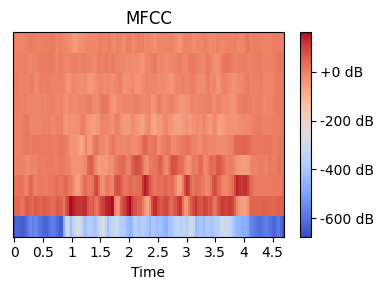

In [4]:
from matplotlib import pyplot as plt

# Plotting the MFCCs
plt.figure(figsize=(4,3))
librosa.display.specshow(mfcc, x_axis='time', sr=sr1)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()


Nous allons résumer ces coefficients en calculant leur moyenne temporelle. Ainsi, chaque fichier audio doit être transformé par un vecteur de taille 13:

In [5]:
mfcc_moyenne = mfcc.mean(axis=1)
mfcc_moyenne

array([-447.81406  ,   63.020832 ,   30.160309 ,    7.9655695,
          2.1016788,  -22.293121 ,   -7.862449 ,  -12.084611 ,
         -1.8244218,   -6.8137836], dtype=float32)

On construit donc le dataset avec la fonction suivante:


In [6]:
import pandas as pd

folder_path = "data/raw/"
n_recordings = 50
n_coefs = 10
data = []
for gender in ["m", "f"]:
    for speaker in range(1, 6):
        for recording_id in range(1, n_recordings + 1):
            file_name = "%s%04d_us_%s%04d_%05d.wav" %(gender, speaker, gender, speaker, recording_id)
            y, sr = librosa.load(folder_path + file_name)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_coefs).mean(axis=1)

            speaker_id = speaker - 1
            if gender == "f":
                speaker_id += 5
            row_data = {
                'FileName': file_name,
                'Gender': gender,
                'SpeakerID': speaker_id,
                'RecordingID': recording_id,
            }
            for i in range(n_coefs):
                row_data[f'MFCC_{i+1}'] = mfcc[i]
            
            data.append(row_data)

df = pd.DataFrame(data)

In [7]:
df.head()

,FileName,Gender,SpeakerID,RecordingID,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,m0001_us_m0001_00001.wav,m,0,1,-432.045410,119.769264,-3.836545,25.336601,-13.802796,16.731417,-2.733351,2.620322,-9.290769,3.606286
1,m0001_us_m0001_00002.wav,m,0,2,-448.635986,114.177414,-5.153250,16.764275,-20.626694,20.666159,-5.741007,9.305303,-5.688131,0.833428
2,m0001_us_m0001_00003.wav,m,0,3,-433.696320,94.268814,-3.704444,24.321095,-15.773800,16.456261,0.998079,5.189481,-8.003875,4.879942
3,m0001_us_m0001_00004.wav,m,0,4,-427.338989,113.769791,-8.063370,25.546103,-15.735123,12.846508,-0.483539,5.328898,-16.783321,1.889776
4,m0001_us_m0001_00005.wav,m,0,5,-412.676575,102.270454,-9.136461,29.005512,-12.034924,23.754642,-7.142555,-0.976251,-14.627462,3.513205


# Partie I:
#### 1. Effectuez une PCA sur les coefficients MFCC en visualisant le genre avec deux couleurs différentes. 


In [8]:
# Séparation des coefficients MFCC et des labels de genre
X = df[[f'MFCC_{i+1}' for i in range(n_coefs)]]
y = df['Gender']

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('reducer', PCA(3))])
X_standardisé_pca = pipe.fit_transform(X)
print('la variance expliquée pour chaque composante principale:\n',pipe['reducer'].explained_variance_ratio_)

n_composent=len(pipe['reducer'].explained_variance_ratio_) # stocker le nombre de composants utilisés
print(f"le modéle explique : {round(float(pipe['reducer'].explained_variance_ratio_.sum()*100) , 2)}% de varience")

la variance expliquée pour chaque composante principale:
 [0.24862565 0.19902487 0.14183636]
le modéle explique : 58.95% de varience


In [10]:
L=[]
for i in range (n_composent):
    s="PCA"+str(i+1)
    L.append(s)
# Ajoute les colones PCA à DataFrame 
X_pca_df = pd.DataFrame(X_standardisé_pca, columns=L)

# Ajoutez la variable cible (Gender) 
X_pca_df['Gender'] = y

visualisation la résultat de ACP 

<Figure size 1000x800 with 0 Axes>

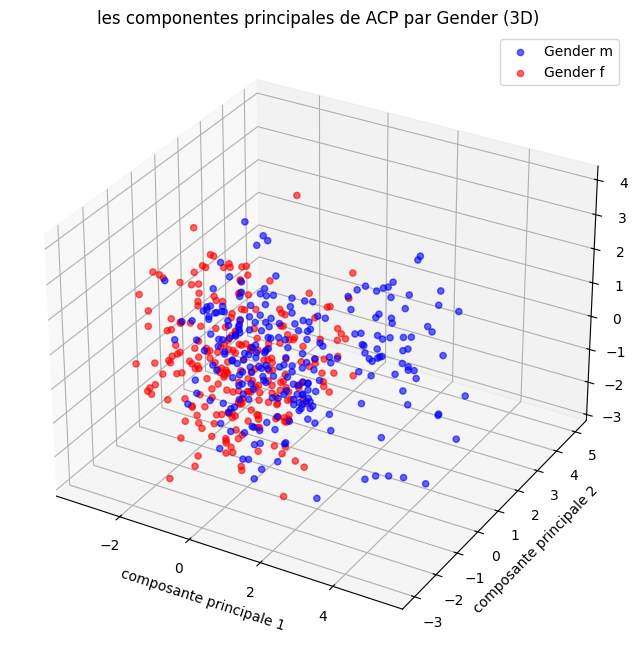

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(10, 8))

# Check the number of components
if n_composent == 2:
    # 2D scatter plot based on gender
    for gender, color in zip(['m', 'f'], ['blue', 'red']):
        subset = X_pca_df[X_pca_df['Gender'] == gender]
        plt.scatter(subset['PCA1'], subset['PCA2'], label=f"Gender {gender}", alpha=0.6, c=color)

    plt.title("les componentes principales de ACP par Gender (2D)")
    plt.xlabel("composante principale 1")
    plt.ylabel("composante principale 2")
    plt.legend()
    plt.show()

elif n_composent == 3:
    # 3D scatter plot based on gender
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for gender, color in zip(['m', 'f'], ['blue', 'red']):
        subset = X_pca_df[X_pca_df['Gender'] == gender]
        ax.scatter(subset['PCA1'], subset['PCA2'], subset['PCA3'], label=f"Gender {gender}", alpha=0.6, color=color)

    ax.set_title("les componentes principales de ACP par Gender (3D)")
    ax.set_xlabel("composante principale 1")
    ax.set_ylabel("composante principale 2")
    ax.set_zlabel("composante principale 3")
    ax.legend()
    plt.show()
else:
    print("impossible de visualisé plus de 3 composentes")

In [12]:
#construire en une nouvelle data frame avec les composents de ACP
new_df = pd.concat([df.iloc[:,:4],X_pca_df.iloc[:,:-1]],axis=1)
new_df

,FileName,Gender,SpeakerID,RecordingID,PCA1,PCA2,PCA3
0,m0001_us_m0001_00001.wav,m,0,1,2.091275,1.691915,1.077103
1,m0001_us_m0001_00002.wav,m,0,2,1.896751,0.703576,1.691942
2,m0001_us_m0001_00003.wav,m,0,3,1.815253,1.029027,0.778088
3,m0001_us_m0001_00004.wav,m,0,4,1.264953,2.437297,1.254002
4,m0001_us_m0001_00005.wav,m,0,5,1.089236,2.334086,1.149189
...,...,...,...,...,...,...,...
495,f0005_us_f0005_00046.wav,f,9,46,-1.878812,2.944184,-1.692674
496,f0005_us_f0005_00047.wav,f,9,47,0.222759,0.075169,-1.641073
497,f0005_us_f0005_00048.wav,f,9,48,0.235240,-0.007085,-1.214178
498,f0005_us_f0005_00049.wav,f,9,49,0.543555,-0.120185,-2.323057


#### 2. On suspecte que les enregistrements du `speaker` 4 forment deux sous-groupes très distincts: les `recordingID` paires et impaires. Effectuez un test pour vérifier cette hypothèse.

Test de Hotelling à deux échantillons dépendants

In [13]:
#on consédére que les échantillons sont dépendantes
import numpy as np
from scipy.stats import f ##f signifie la loi de Fisher
from numpy.linalg import inv

#diveser les enregistrements du speaker 4 en deux sous-groupes avec les recordingID paires et impaires
df_speaker_4 =new_df[new_df["SpeakerID"]==4]
df_paire_speacker4 = df_speaker_4[df_speaker_4["RecordingID"] % 2 ==0]
df_impare_speaker4 = df_speaker_4[df_speaker_4["RecordingID"] % 2 !=0]

# Sélection des colonnes PCA pour les deux groupes
PCA_clos_impaire =df_impare_speaker4[[f'PCA{i+1}' for i in range(n_composent)]]
impaire =np.array(PCA_clos_impaire)
PCA_clos_paire =df_paire_speacker4[[f'PCA{i+1}' for i in range(n_composent)]]
paire =np.array(PCA_clos_paire)

# Vérifier que les deux groupes ont la même taille (nécessaire pour les échantillons appariés)
assert paire.shape == impaire.shape, "Les échantillons appariés doivent avoir la même taille"

# Calcul des différences entre les paires
Z_diff = paire - impaire

# Nombre d'observations et nombre de dimensions 
n = Z_diff.shape[0]  
d = Z_diff.shape[1]  

# Moyenne 
mean_diff = Z_diff.mean(axis=0)

# Matrice de covariance 
cov_diff = np.cov(Z_diff, rowvar=False)

# Calcul de la statistique de Hotelling T² 
T2_statistic = n * mean_diff.T @ inv(cov_diff) @ mean_diff

# Conversion de la statistique T² en statistique F
F_statistic = (T2_statistic * (n - d)) / (d * (n - 1))
p_value = 1 - f.cdf(F_statistic, d, n - d)
#afficher les résultats
print(f"Statistique de Hotelling T2: {T2_statistic}")
print(f"Statistique F correspondante: {F_statistic}")
print(f"Valeur de p: {p_value}")


Statistique de Hotelling T2: 0.13597327737997797
Statistique F correspondante: 0.041547390310548826
Valeur de p: 0.9884029986561547


#### 3. Proposez une analyse statistique (et effectuez la) pour évaluer si différence entre les hommes et les femmes est significative. 


In [14]:
#diveser les enregistrements en deux sous-groupes les hommes et les femmes
df_hommes=new_df[new_df["Gender"]=="m"]
df_femmes=new_df[new_df["Gender"]=="f"]

Test de Hotelling à deux échantillons indépendants

In [15]:
#on considére les deux échantillons sont independents

# Sélection des colonnes PCA pour les deux groupes
PCA_clos_hommes =df_hommes[[f'PCA{i+1}' for i in range(n_composent)]]
hommes =np.array(PCA_clos_hommes)
PCA_clos_femmes =df_femmes[[f'PCA{i+1}' for i in range(n_composent)]]
femmes =np.array(PCA_clos_femmes)

# Nombre d'observations et nombre de dimensions
n1= hommes.shape[0]
n2=femmes.shape[0]
d=hommes.shape[1]

#Moyennes
mean_hommes = hommes.mean(axis=0)
mean_femmes = femmes.mean(axis=0)

# Matrice de covariance
cov_hommes= np.cov(hommes ,rowvar=False)
cov_femmes = np.cov(femmes ,rowvar=False)

# Matrice de covariance agr
cov_agr = ((n1 - 1) * cov_hommes + (n2 - 1) * cov_femmes) / (n1 + n2 - 2)

#la statistique de test de Hotelling
T2_statistic = (n1 * n2 / (n1 + n2)) * (mean_hommes - mean_femmes).T @ inv(cov_agr) @ (mean_hommes - mean_femmes)

# Conversion de la statistique T2 en statistique F
F_statistic = (T2_statistic * (n1 + n2 - d - 1)) / (d * (n1 + n2 - 2))
p_value = 1 - f.cdf(F_statistic, d, n1 + n2 - d - 1)

#afficher les résultats
print(f"Statistique de Hotelling T2: {T2_statistic}")
print(f"Statistique F correspondante: {F_statistic}")
print(f"Valeur de p_value: {p_value}")

Statistique de Hotelling T2: 157.6099300129272
Statistique F correspondante: 52.32565280214986
Valeur de p_value: 1.1102230246251565e-16


#### 4. Compte tenu de ce résultat, comment peut-on implémenter un modèle de prédiction (avec numpy seulement) du sexe basé sur le calcul d'une distance ? 


In [16]:
from scipy.spatial import distance
inv_cov_hommes = np.linalg.inv(cov_hommes)
inv_cov_femmes = np.linalg.inv(cov_femmes)

# fonction de prédiction avec la distance de Mahalanobis
def predict_gender_mfcc(X_vec):
    dist_homme = distance.mahalanobis(X_vec, mean_hommes, inv_cov_hommes)
    dist_femme = distance.mahalanobis(X_vec, mean_femmes, inv_cov_femmes)
    return 'm' if dist_homme < dist_femme else 'f'

# Prédiction sur les enregistrements de test 
new_df['PredictedGender'] = new_df[[f'PCA{i+1}' for i in range(n_composent)]].apply(predict_gender_mfcc, axis=1)

# Calcul de l'accuracy
accuracy = (new_df['PredictedGender'] == new_df['Gender']).mean()
print(f"Précision du modèle de prédiction du genre est : {accuracy * 100:.2f}%")

Précision du modèle de prédiction du genre est : 71.40%


# Partie II: Reconnaissance vocale
On souhaite désormais apprendre à prédire `Y = speaker_id` avec les données `X = MFCCS` en utilisant des modèles de classification (avec scikit-learn). On découpe le dataset en deux parties:
- `(X_train, y_train)`: utilisé pour "entrainer" le modèle, c-à-d on suppose que les `y_train` sont connues.
- `(X_test, y_test)`: utilisé pour "tester" le modèle, c-à-d on suppose que les `y_train` ne sont pas connues à l'avance et sont utilisés uniquement après avoir entrainé le modèle pour l'évaluer.


In [17]:
from sklearn.model_selection import train_test_split

X = df[[f"MFCC_{i}" for i in range(1, 11)]].values
y = df.SpeakerID.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, test_size=0.25)

#### 5. Évaluez la performance du modèle Naive Bayes en terme de précision de prédiction sur le train et le test. 

Précision du modèle GNB sur les données de test  : 72.80%
Précision du modèle GNB sur les donées de train: 84.00%


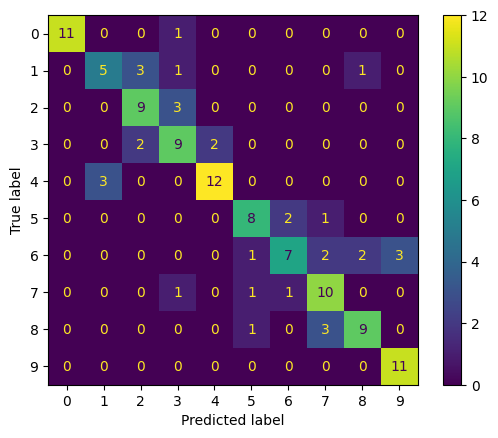

In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score)

# Initialisation et entraînement du modèle Naive Bayes
modèle=GaussianNB()
modèle.fit(X_train,y_train)

# Prédictions sur les ensembles d'entraînement et de test
y_prédites_test = modèle.predict(X_test)
y_prédites_train = modèle.predict(X_train)

# Calcul de la précision
accuracy_test=accuracy_score(y_prédites_test,y_test)
accuracy_train=accuracy_score(y_prédites_train,y_train)


f1=f1_score(y_prédites_test,y_test, average='macro')
print("Précision du modèle GNB sur les données de test  : {:.2f}%".format(accuracy_test * 100))
print("Précision du modèle GNB sur les donées de train: {:.2f}%".format(accuracy_train * 100))

cm=confusion_matrix(y_test,y_prédites_test)
cmMP=ConfusionMatrixDisplay(confusion_matrix=cm)
cmMP.plot()

#### 6. Comparez ses performances avec LDA et QDA. Que pouvez-vous conclure ?

LDA

Précision du modèle LDA sur les données de test : 85.60%
Précision du modèle LDA sur les données de train : 91.73%


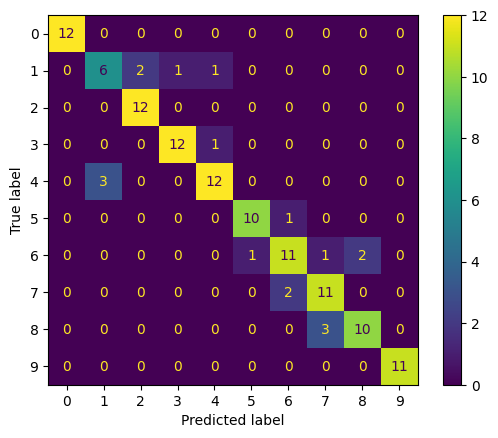

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

LDA=LinearDiscriminantAnalysis()
LDA.fit(X_train,y_train)

y_prédites_test_LDA = LDA.predict(X_test)
y_prédites_train_LDA = LDA.predict(X_train)

accuracy_test_LDA = accuracy_score(y_test, y_prédites_test_LDA)
accuracy_train_LDA = accuracy_score(y_train, y_prédites_train_LDA)

print("Précision du modèle LDA sur les données de test : {:.2f}%".format(accuracy_test_LDA * 100))
print("Précision du modèle LDA sur les données de train : {:.2f}%".format(accuracy_train_LDA * 100))

cm=confusion_matrix(y_test,y_prédites_test_LDA)
cmMP=ConfusionMatrixDisplay(confusion_matrix=cm)
cmMP.plot()

QDA

Précision du modèle QDA sur les données de test : 88.80%
Précision du modèle QDA sur les données de train : 98.40%


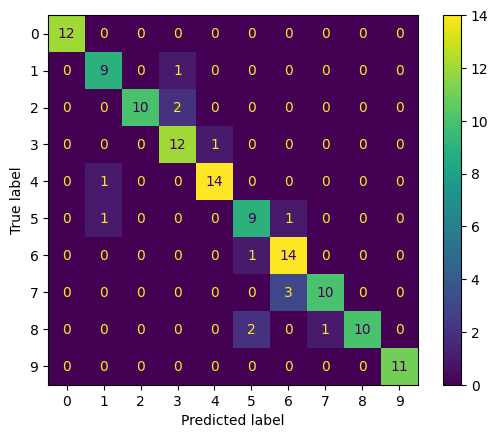

In [20]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

y_prédites_test_QDA = qda.predict(X_test)
y_pred_train_QDA = qda.predict(X_train)

accuracy_test_QDA = accuracy_score(y_test, y_prédites_test_QDA)
accuracy_train_QDA = accuracy_score(y_train, y_pred_train_QDA)

print("Précision du modèle QDA sur les données de test : {:.2f}%".format(accuracy_test_QDA * 100))
print("Précision du modèle QDA sur les données de train : {:.2f}%".format(accuracy_train_QDA * 100))

cm=confusion_matrix(y_test,y_prédites_test_QDA)
cmMP=ConfusionMatrixDisplay(confusion_matrix=cm)
cmMP.plot()

#### 7. On souhaite à présent modéliser la distribution de chaque speaker par un mélange de Gaussiennes. Comment peut-on faire des prédictions avec un tel modèle ?

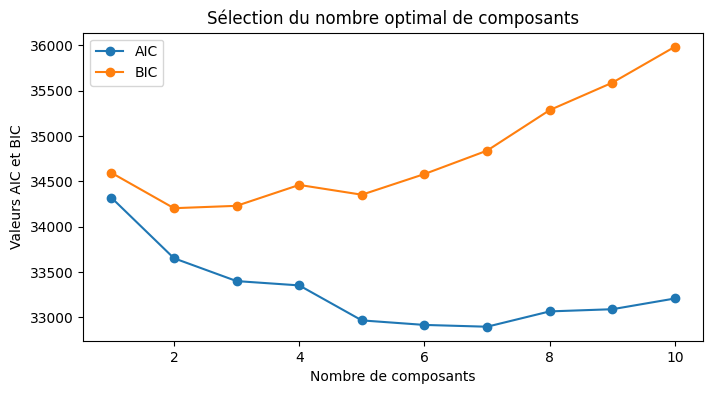

In [21]:
#Sélection du nombre optimal de composants
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

n_components_range = range(1, 11)

aic_values = []
bic_values = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X)  # Entraînement sur l'ensemble des données
    aic_values.append(gmm.aic(X))
    bic_values.append(gmm.bic(X))

plt.figure(figsize=(8, 4))
plt.plot(n_components_range, aic_values, label='AIC', marker='o')
plt.plot(n_components_range, bic_values, label='BIC', marker='o')
plt.xlabel('Nombre de composants')
plt.ylabel('Valeurs AIC et BIC')
plt.legend()
plt.title('Sélection du nombre optimal de composants')
plt.show()

In [22]:
from sklearn.model_selection import train_test_split

X = df[[f"MFCC_{i}" for i in range(1, 11)]].values
y = df.SpeakerID.values


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, test_size=0.25)
gmm_models = {}

# Ajustement d'un modèle GMM pour chaque  speaker
for speaker in np.unique(y_train):
    X_speaker = X_train[y_train == speaker]
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)  
    gmm.fit(X_speaker)
    gmm_models[speaker] = gmm


y_pred_test = []
for x in X_test:
    scores = {speaker: gmm.score([x]) for speaker, gmm in gmm_models.items()}
    y_pred_test.append(max(scores, key=scores.get))
y_pred_train = []
for x in X_train:
    scores = {speaker: gmm.score([x]) for speaker, gmm in gmm_models.items()}
    y_pred_train.append(max(scores, key=scores.get))

accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)

print("Précision du modèle basé sur GMM sur les données de test : {:.2f}%".format(accuracy_test * 100))
print("Précision du modèle basé sur GMM sur les données de train : {:.2f}%".format(accuracy_train * 100))

Précision du modèle basé sur GMM sur les données de test : 80.00%
Précision du modèle basé sur GMM sur les données de train : 99.73%


#### 8. Comparez les performances du mélange de Gaussienens en essayant plusieurs combinaisaisons de ses arguments (`n_components` et `covariance_type`). Que pouvez-vous conclure ?

Précision du modèle basé sur GMM 1 components et covariance_type=full : 88.00%
Précision du modèle basé sur GMM 1 components et covariance_type=tied : 88.00%
Précision du modèle basé sur GMM 1 components et covariance_type=diag : 73.60%
Précision du modèle basé sur GMM 1 components et covariance_type=spherical : 54.40%
Précision du modèle basé sur GMM 2 components et covariance_type=full : 80.00%
Précision du modèle basé sur GMM 2 components et covariance_type=tied : 88.00%
Précision du modèle basé sur GMM 2 components et covariance_type=diag : 82.40%
Précision du modèle basé sur GMM 2 components et covariance_type=spherical : 60.80%
Précision du modèle basé sur GMM 3 components et covariance_type=full : 67.20%
Précision du modèle basé sur GMM 3 components et covariance_type=tied : 88.00%
Précision du modèle basé sur GMM 3 components et covariance_type=diag : 80.80%
Précision du modèle basé sur GMM 3 components et covariance_type=spherical : 73.60%
Précision du modèle basé sur GMM 4 co

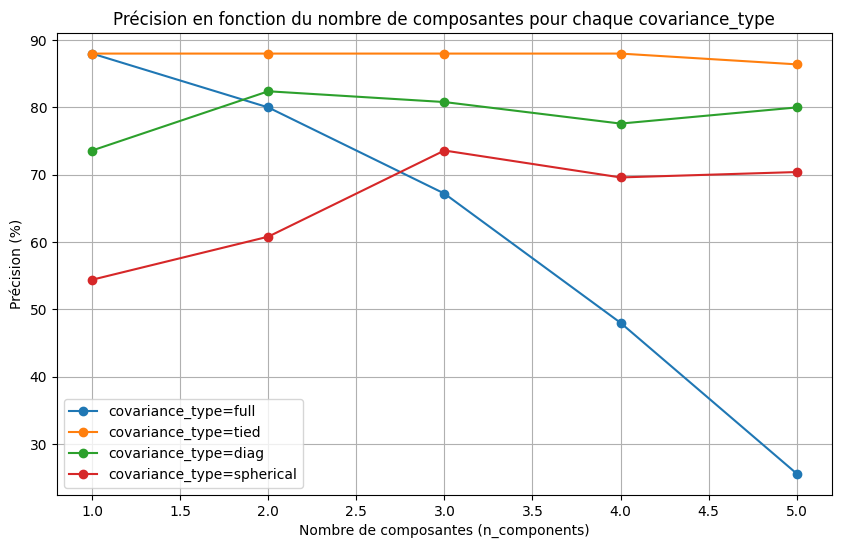

In [23]:
gmm_models = {}
n_components=range(1,6)
covariance_type=['full','tied','diag','spherical']
accuracies = {c: [] for c in covariance_type}

for n in n_components:
    for c in covariance_type:
        for speaker in np.unique(y_train):
            X_speaker = X_train[y_train == speaker]
            gmm = GaussianMixture(n_components=n, covariance_type=c, random_state=42)  
            gmm.fit(X_speaker)
            gmm_models[speaker] = gmm

        y_pred = []
        for x in X_test:
            scores = {speaker: gmm.score([x]) for speaker, gmm in gmm_models.items()}
            
            y_pred.append(max(scores, key=scores.get))
            
        accuracy = accuracy_score(y_test, y_pred)
        accuracies[c].append(accuracy * 100)
        print("Précision du modèle basé sur GMM {} components et covariance_type={} : {:.2f}%".format(n,c,accuracy * 100))


plt.figure(figsize=(10, 6))
for c in covariance_type:
    plt.plot(n_components, accuracies[c], marker='o', label=f'covariance_type={c}')
plt.xlabel("Nombre de composantes (n_components)")
plt.ylabel("Précision (%)")
plt.title("Précision en fonction du nombre de composantes pour chaque covariance_type")
plt.legend()
plt.grid(True)
plt.show()


#### 10: Evaluez la performance avec le modèle de classification de votre choix (scikit-learn) et interpretez le résultat. Le meilleur score sur des données de validation (privées) aura une note supplémentaire.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score



# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modèle de régression logistique
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train_scaled, y_train)
y_test_pred_log_reg = log_reg_model.predict(X_test_scaled)
accuracy_log_reg = accuracy_score(y_test, y_test_pred_log_reg)
print("La précision de la régression logistique:", accuracy_log_reg*100,"%")





La précision de la régression logistique: 88.0 %


In [25]:
# Modèle SVM
svm_model = SVC(random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_test_pred_svm = svm_model.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
print("La précision de SVM :", accuracy_svm*100,"%")


La précision de SVM : 88.0 %


In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# le tuning pour la régression logistique
log_reg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  
}
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_grid = GridSearchCV(log_reg_model, log_reg_params, cv=5, scoring='accuracy')
log_reg_grid.fit(X_train_scaled, y_train)

# le tuning pour SVM
svm_params = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
svm_model = SVC(random_state=42)
svm_grid = GridSearchCV(svm_model, svm_params, cv=5, scoring='accuracy')
svm_grid.fit(X_train_scaled, y_train)

# Meilleurs modèles
best_log_reg = log_reg_grid.best_estimator_
best_svm = svm_grid.best_estimator_

print("Meilleur modèle RL:", best_log_reg)
print("Meilleur score pour RL:", log_reg_grid.best_score_)
print("Meilleur modèle SVM:", best_svm)
print("Meilleur score pour SVM:", svm_grid.best_score_)

Meilleur modèle RL: LogisticRegression(C=1, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')
Meilleur score pour RL: 0.8525
Meilleur modèle SVM: SVC(C=100, random_state=42)
Meilleur score pour SVM: 0.8775000000000001


In [27]:
# Voting Classifier avec les meilleurs modèles de GridSearchCV
modèle_de_voting = VotingClassifier(estimators=[
    ('log_reg', best_log_reg),
    ('svm', best_svm)
], voting='hard')


modèle_de_voting.fit(X_train_scaled, y_train)

# évaluation du modèle 
y_val_pred_voting = modèle_de_voting.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_val_pred_voting)
report_voting = classification_report(y_val, y_val_pred_voting)

# résultats

print("La précision de Voting Classifier sur l'ensemble de validation :", accuracy*100,"%")


La précision de Voting Classifier sur l'ensemble de validation : 89.0 %
